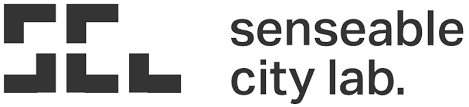

 ## **CityScanner: Introduction to Hyperlocal Environmental Sensing**


---

##Overview
Engaging with and analyzing environmental data is a powerful tool to better understand the world around you. This notebook shows how to:

*  Create time series graphs
*  Develop basic maps with environmental data
*   Perform clustering analysis on pollution hotspots


##Prerequisites
* A **Google G-Suite Account** 
* **Google CoLab** extension installed
* A **copy of the notebook and .csv files** in a single folder in your Google Drive



##Part 0: Setup

***Start by making sure you have unzipped the folder provided to you into your google drive to satisfy the prerequisites above.***

Here, we are going to call Python libraries - modules of code that allow us to have different types of functionality in our program.

In [ ]:
#Block 1
#this block is going to allow the notebook to connect to your google drive so you can interact with it
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Block 2
#here, we install the tool we are going to use to make some maps, called Folium 
%%capture
!pip install folium

In [ ]:
#Block 3
#this block of code is where we get the infrastructure for the notebook set up, by calling libraries
import csv
import numpy as np

#these libraries will help us read in and format the data correctly
import pytz
import time
import pandas as pd
from datetime import datetime
import os

#these libraries will help us with our time series analysis
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates

#these libraries will support the mapping work
import folium 
from folium import plugins
import branca.colormap as cm
from matplotlib.dates import DateFormatter
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [ ]:
#Block 4
#adjust the path below to match your google drive setup! please use the format below: 
#os.chdir('/content/drive/My Drive/YOURNAME_SALWorkshop')

## Part 1 -Time Series 


Now, we will read in the data from a CityScanner deployment in The Bronx, New York City. You can switch out the below example files with data from your own deployments in the future! 

In [ ]:
#Block 5

#below are the files for temp/humidity, PM and NO2 data. 
th = "NYC_Pilot1.csv"
pm = "NYC_Pilot2_PM_Part1.csv"
no2 = "NYC_Pilot2_NO2_Part1.csv"

#the line of code below reads in the data file for temperature and humidity data!
thdata = pd.read_csv(th, engine='python') #contents of data
pmdata = pd.read_csv(pm, engine='python') #contents of data
no2data = pd.read_csv(no2, engine='python') #contents of data


Then we set the timezone so the code knows what it is, and print ourselves a message to verify we read it in correctly.

In [ ]:
#Block 6
tz = pytz.timezone('US/Eastern')
print("Data read")

In [ ]:
#Block 7

#here, we will show the first few lines of the data files. Check out what the start date and times are! 
thdata.head()

#uncomment the line below to see the start of the PM data file!
#pmdata.head()

#uncomment the line below to see the start of the NO2 data file!
#no2data.head()

In [ ]:
#Block 8
#here, we will show the last few lines of the data files. Check out what the ending date and times are! 
thdata.tail()

#uncomment the line below to see the end of the PM data file!
#pmdata.tail()

#uncomment the line below to see the end of the NO2 data file!
#no2data.tail()

Time to warm up with a map. Let's find some parameters from the deployment in time series - let's start with temperature and then try PM2.5! 

Let's get some basic information about temperature from this deployment - 
- The average temperature the devices saw
- The maximum temperatures the devices saw
- The minimum temperature the devices saw 

In [ ]:
#Block 9
avg = pmdata['temperature'].mean()
max = pmdata['temperature'].max()
min = pmdata ['temperature'].min()


#now that we have those values, let's print them out so we can take a look
print("Avg value",avg, "Max value",max, "Min value",min)


#th file variable names
#temperature, humidity

#pm file variable names
#pm25

#no2 file variable names 
#no2

Now let's make a plot of the total temperature during the time we have collected the data for.

In [ ]:
#Block 10
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(thdata["time"], thdata["temperature"], 'r')
ax.set(xlabel="time",
       ylabel="Temp(C)",
       title="Time Series")
tick_spacing = 6000
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=45);
plt.show()


In [ ]:
#Block 11
#this is a helpful image, but what if we just want to know the time series for one week, or another period of time?
#we can select the time we want to create a time series for using the code below.


fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(thdata["time"], thdata["temperature"], 'r')

ax.set(xlabel="time",
       ylabel="Temp(C)",
       title="Time Series",
       xlim=["2021/11/02 09:33", "2021/11/02 09:42"]) #set the time range you are interested in using in the square brackets!
tick_spacing = 20                                                     #play with this number to increase or decrease the number of x axis labels
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=45);
plt.show() 

#you can modify the pm and no2 files using a similar structure as above! 

Great - now replace the temperature parameters with humidity, and even pm2.5 or no2 from the other data files. Rerun the code and see what you get! What does the data tell you? 

## Part 2 - Mapping + Hotspot Analysis 

Now that we created some time series graphs, we will work on creating maps. Let's start with a PM2.5 map! 

In [ ]:
#Block 12
#we're going to make a map. we start by setting a center point for the map to display the data
coords = pmdata.loc[:,['lat','long']].values #lat and lon are collected from CityScanner GPS
start_point=coords[0]

In [ ]:
#Block 13
#here, we set up the specifications for the map
newmap = folium.Map(location= start_point, tiles='Stamen Terrain', zoom_start=14)
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=21)
colormap.caption = 'PM 2.5 (ug/m^3)' #change this to represent the variable of interest! 
colormap.add_to(newmap)


#this will loop through the data and show us where it's coming from
#each point on the map will display the PM2.5 value from that spot, in micrograms per cubic meter.
for i,row in pmdata.iterrows():
    #folium.CircleMarker((row.lat,row.long), radius=4, weight=1, color='blue', fill_color='blue', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)
    folium.CircleMarker((row.lat,row.long), radius=4, weight=1, color=colormap(pmdata.iloc[i]['pm25']), fill ='true', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)

newmap.add_child(colormap)
#here we save an html version of the map - you can zoom in and out of it and interact with it!
#this .html file will be saved to your google drive folder. Download it to your computer and open it to interact with it! 
newmap.save('newmap.html')
#you may need to refresh the page on your google drive folder to see the updated map! 
#you may also need to close a few tabs so you don't run out of memory when opening the map :)


#note - you can also create a map for a subset of the total deployment time by calling the "thdatamod", "pmdatamod", or "no2datamod" variable above!

Now that we have our point map, showing us where pm2.5 values and potential hotspot locations are, let's do some clustering. This will allow us to see where multiple measurements exceed the threshold value, potentially indicating a local source of pollution or pollution transport.

In [ ]:
#Block 14
#let's start by setting 10 as the threshold value. Change this and see how the number of hotspots changes! 
pmdata = pmdata.loc[(pmdata['pm25'] > 10)]

In [ ]:
#Block 15
#hierarchical clustering code 

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata 
coords = hotspots.loc[:,['lat','long']].values

#preprocessing for hotspot clustering
#we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088 

#epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian 

#min_samples is the minimum cluster size for a hotspot to be formed, and here we also call the haversine metric
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))-(1 if -1 in set(cluster_labels) else 0)
outliers = coords[cluster_labels == -1]

#here is where we create the clusters after doing the background math above
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
outliers = coords[cluster_labels == -1]
print('Number of clusters: {}'.format(num_clusters))



In [ ]:
#Block 16
#this portion of the code is going to tell us where the map should show up!

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
                                      
                                      
centermost_points = clusters.map(get_centermost_point)
start_point=centermost_points[0]

#setting up the specifications for the map
hotspotmap = folium.Map(location= start_point, tiles='Stamen Terrain', zoom_start=14)
points=[]
#add a markers
for index, row in hotspots.iterrows():
    point=(row['lat'] row['long'])
    if point not in points:
        new_point=(row['lat'], row['long'])
        points.append(new_point)      
for rep in centermost_points:
    folium.CircleMarker(location=rep, color='blue', fill=True, fill_color='blue',radius=15).add_to(hotspotmap)
for each in points:
    folium.CircleMarker(location=each, popup=(row.pm25), color='red', fill=True, fill_color='red',radius=7).add_to(hotspotmap)
    hotspotmap.add_child(folium.LatLngPopup())
  

#interactive html map showing hotspot clusters
hotspotmap.save('HotspotMap.html')

##Summary
Now that you have finished going through this notebook, you should be able to create time series graphs, basic maps, and perform clustering analysis techniques on hyperlocal environmental data. Additionally, you should have a basic knowledge of some of the different pollutants that can be measured to tell us more about the quality of our immediate environment.



##Resources and references
Below you can find links to some of the CityScanner papers, some of the reference materials shown in the presentation, and some reference documentation for some of the python libraries! 

CityScanner Papers:
*   [Challenges of Drive-By IoT Sensing for Smart Cities: City Scanner Case Study](https://senseable.mit.edu/papers/pdf/20181012_Anjomshooa-etal_ChallengesDrive-by_Purba.pdf)
*  [ City Scanner: Building and Scheduling a Mobile
Sensing Platform for Smart City Services](https://senseable.mit.edu/papers/pdf/20180522_Anjomshoaa-etal_CityScanner_IEEE-IoT.pdf)
* [Air quality monitoring using mobile low-cost sensors mounted on trashtrucks: Methods development and lessons learned](https://senseable.mit.edu/papers/pdf/20200601_deSouza-etal_AirQuality_SCS.pdf)

Reference Materials:
*  [NYCCAS Data](https://nyc-ehs.net/nyccas2020/web/report#Pollutant_Maps)
*  [United States EPA](https://www.epa.gov/)
*  [World Health Organization](https://www.who.int/)

Python Library Documentation:
*  [Folium](http://python-visualization.github.io/folium/)
*  [Pandas](https://pandas.pydata.org/)
* [Matplotlib](https://matplotlib.org/)


